In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *



astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension

noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
npos = 49  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = 1200+2*pad

show = True

flg = f'{n}_{1}_{npos}_{z1c}_{noise}_code'
path = f'/data2/vnikitin/nfp_codes'

## Read data

In [3]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'{path}/data/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/data/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/data/code_{flg}.npy')
shifts_code = np.load(f'{path}/data/shifts_code_{flg}.npy')[:, :npos]



/data2/vnikitin/nfp_codes/data/data_0_512_1_49_-0.0195_0_code.tiff


# Construct operators


In [4]:
def _fwd_holo(psi, shifts_code, prb):
    prb = cp.array(prb)
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])

        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        psir = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]

        # multiply by the probe
        psir *= prbr
        
        # propagate to the detector
        psir = G(psir, wavelength, voxelsize, distances[i])
        
        # unpad
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code,  prb)

def _adj_holo(data, shifts_code, prb):
    prb = cp.array(prb)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        prbr = cp.tile(prb,[data.shape[0],1,1])        
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))

        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psir *= cp.conj(prbr)
        psir = cp.pad(psir,((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi

@gpu_batch
def _adj_holo_prb(data, shifts_code, psi):
    psi = cp.array(psi)
    shifts_code = cp.array(shifts_code)       
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))        
        psir = psi.copy()

        prbr = GT(prbr, wavelength, voxelsize, distances[j])
        psir = S(psir, shifts_code[:, j])
        psir = psir[:, ne//2-n//2-pad:ne//2+n//2+pad, ne//2-n//2-pad:ne//2+n//2+pad]
        prbr *= cp.conj(psir)

        prb += prbr
    return prb

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, prb)
def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, prb)
def adj_holo_prb(data, psi):
    return np.sum(_adj_holo_prb(data, shifts_code, psi), axis=0)[np.newaxis]

# adjoint tests
data = cp.array(data00)+0.5*1j*cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(prb1*cp.conj(arr4))}==\n{cp.sum(arr2*cp.conj(arr2))}')

(19632952+1.07568359375j)==
(19632952-5.465128197101876e-05j)
(19632950-0.16343164443969727j)==
(19632952-5.465128197101876e-05j)


In [5]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir#cp.pad(psir,((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))                
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')



(23553720+1.443875789642334j)==
(23553720-1.5848499596016197e-11j)
(15706361-0.1342606544494629j)==
(15706361+4.0612278098706156e-05j)


### Divide by reference image for 1step Paganin reconsturction

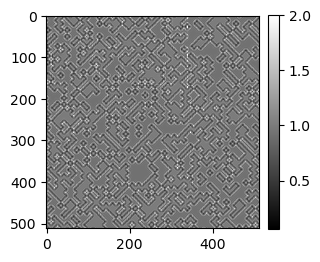

In [6]:
ref0 = cp.array(ref0)
data00 = cp.array(data00)

rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=2)

/tmp/ipykernel_887786/3561898921.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
/tmp/ipykernel_887786/3561898921.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])


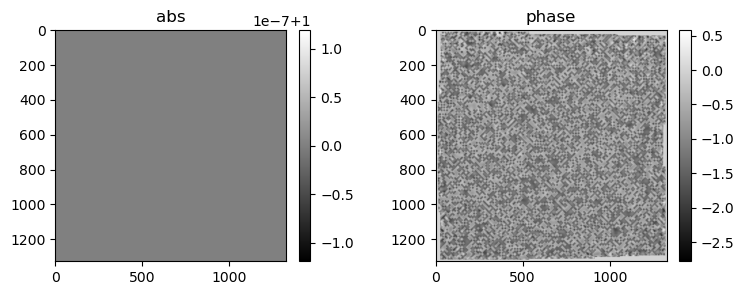

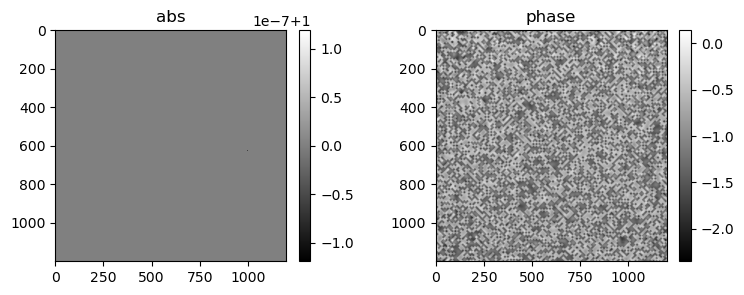

In [7]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
for j in range(0,npos):
    r = multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 5e-2)    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)


In [8]:
@gpu_batch
def _fwd_holo0(prb):
    data = cp.zeros([1, npos, n, n], dtype='complex64')
    for j in range(npos):
        # ill shift for each acquisition
        prbr = S(prb)
        # propagate illumination
        data[:, j] = G(prbr, wavelength, voxelsize, distances[0])[:, pad:n+pad, pad:n+pad]
    return data
def fwd_holo0(prb):
    return _fwd_holo0(prb)

@gpu_batch
def _adj_holo0(data):
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        # ill shift for each acquisition
        prbr = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += prbr
    return prb
def adj_holo0(data):
    return _adj_holo0(data)

# adjoint test
data = cp.array(data00[0, :])
ref = cp.array(ref0)
prb1 = cp.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = cp.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)

print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(32053148-0.5620951652526855j)==
(32053144-0.0004590433673001826j)


#### Reconstruction with the CG (Carlsson) with Hessians

0) gammah=array(0.03955965, dtype=float32), err=2.04294e+04


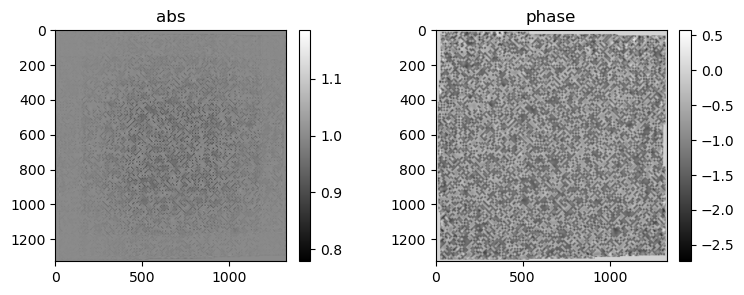

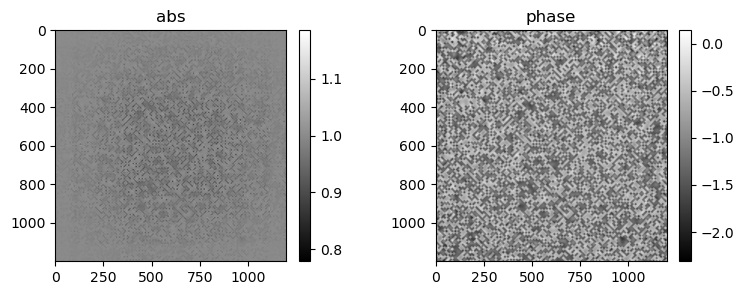

1) gammah=array(0.06144466, dtype=float32), err=1.02815e+04
2) gammah=array(0.07313432, dtype=float32), err=6.76442e+03
3) gammah=array(0.07838394, dtype=float32), err=4.92989e+03
4) gammah=array(0.08336007, dtype=float32), err=3.73199e+03
5) gammah=array(0.08137713, dtype=float32), err=2.94604e+03
6) gammah=array(0.08022073, dtype=float32), err=2.40735e+03
7) gammah=array(0.08210804, dtype=float32), err=2.02382e+03
8) gammah=array(0.08529315, dtype=float32), err=1.73123e+03
9) gammah=array(0.09026704, dtype=float32), err=1.48095e+03
10) gammah=array(0.09091613, dtype=float32), err=1.26073e+03
11) gammah=array(0.08815339, dtype=float32), err=1.07365e+03
12) gammah=array(0.08716859, dtype=float32), err=9.20986e+02
13) gammah=array(0.08927453, dtype=float32), err=7.89935e+02
14) gammah=array(0.08755852, dtype=float32), err=6.78431e+02
15) gammah=array(0.08659749, dtype=float32), err=5.86522e+02
16) gammah=array(0.08673334, dtype=float32), err=5.10678e+02
17) gammah=array(0.08685566, dtyp

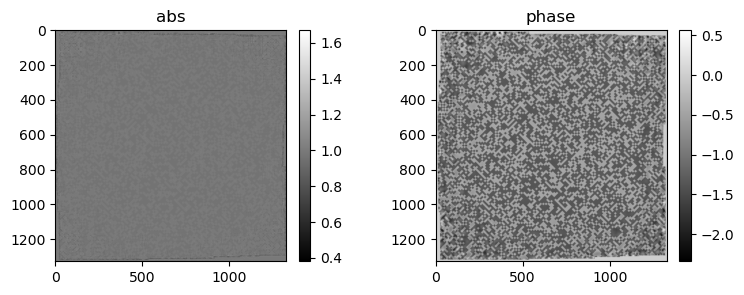

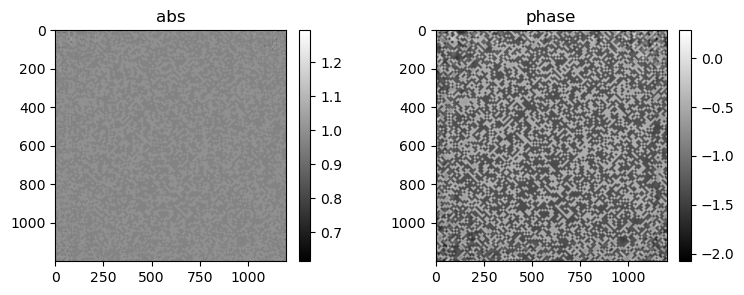

33) gammah=array(0.09250276, dtype=float32), err=1.08377e+02
34) gammah=array(0.0925192, dtype=float32), err=1.00996e+02
35) gammah=array(0.09226683, dtype=float32), err=9.42701e+01
36) gammah=array(0.09187261, dtype=float32), err=8.81493e+01
37) gammah=array(0.09117362, dtype=float32), err=8.25858e+01
38) gammah=array(0.09099803, dtype=float32), err=7.74995e+01
39) gammah=array(0.09107868, dtype=float32), err=7.28388e+01
40) gammah=array(0.09154703, dtype=float32), err=6.85451e+01
41) gammah=array(0.09219808, dtype=float32), err=6.45616e+01
42) gammah=array(0.09236439, dtype=float32), err=6.08556e+01
43) gammah=array(0.0930775, dtype=float32), err=5.74014e+01
44) gammah=array(0.09337095, dtype=float32), err=5.41817e+01
45) gammah=array(0.0942563, dtype=float32), err=5.11662e+01
46) gammah=array(0.09450246, dtype=float32), err=4.83411e+01
47) gammah=array(0.09450271, dtype=float32), err=4.56972e+01
48) gammah=array(0.0943547, dtype=float32), err=4.32294e+01
49) gammah=array(0.09397651,

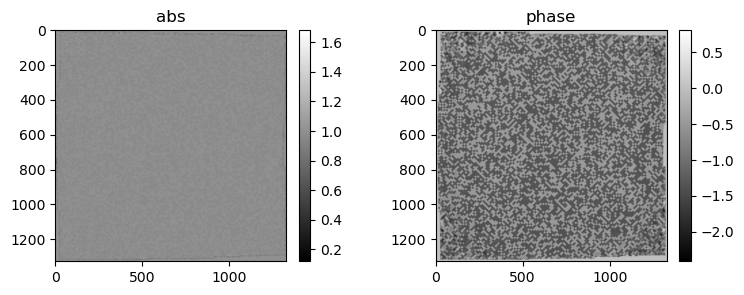

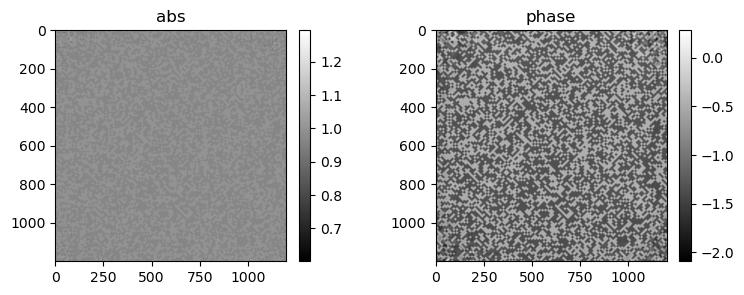

65) gammah=array(0.09368314, dtype=float32), err=1.91408e+01
66) gammah=array(0.0937384, dtype=float32), err=1.83523e+01
67) gammah=array(0.09389778, dtype=float32), err=1.76043e+01
68) gammah=array(0.09394273, dtype=float32), err=1.68959e+01
69) gammah=array(0.0939304, dtype=float32), err=1.62260e+01
70) gammah=array(0.09370084, dtype=float32), err=1.55941e+01
71) gammah=array(0.09348914, dtype=float32), err=1.49978e+01
72) gammah=array(0.09353718, dtype=float32), err=1.44347e+01
73) gammah=array(0.09372108, dtype=float32), err=1.39019e+01
74) gammah=array(0.094285, dtype=float32), err=1.33958e+01
75) gammah=array(0.0944522, dtype=float32), err=1.29174e+01
76) gammah=array(0.09478585, dtype=float32), err=1.24658e+01
77) gammah=array(0.09462453, dtype=float32), err=1.20392e+01
78) gammah=array(0.09435751, dtype=float32), err=1.16354e+01
79) gammah=array(0.09385709, dtype=float32), err=1.12529e+01
80) gammah=array(0.09329804, dtype=float32), err=1.08899e+01
81) gammah=array(0.09285197, 

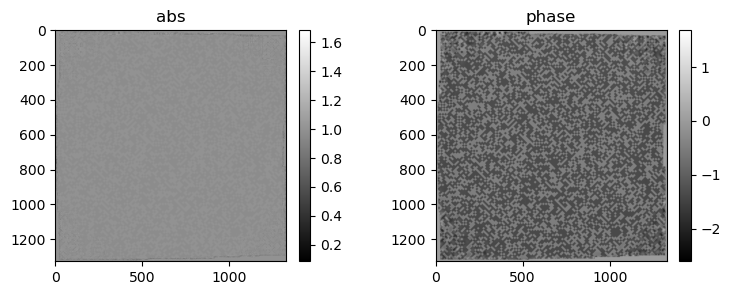

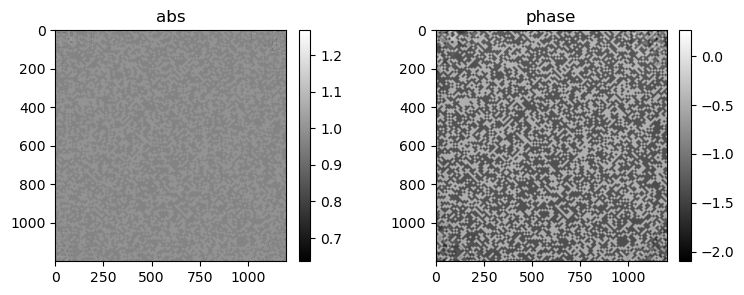

97) gammah=array(0.09440864, dtype=float32), err=6.62414e+00
98) gammah=array(0.09348127, dtype=float32), err=6.45545e+00
99) gammah=array(0.09282812, dtype=float32), err=6.29436e+00
100) gammah=array(0.09295683, dtype=float32), err=6.13941e+00
101) gammah=array(0.09328216, dtype=float32), err=5.98998e+00
102) gammah=array(0.09339806, dtype=float32), err=5.84624e+00
103) gammah=array(0.09390924, dtype=float32), err=5.70777e+00
104) gammah=array(0.09430991, dtype=float32), err=5.57446e+00
105) gammah=array(0.09466474, dtype=float32), err=5.44567e+00
106) gammah=array(0.09451576, dtype=float32), err=5.32176e+00
107) gammah=array(0.09455936, dtype=float32), err=5.20234e+00
108) gammah=array(0.09489677, dtype=float32), err=5.08701e+00
109) gammah=array(0.09488122, dtype=float32), err=4.97594e+00
110) gammah=array(0.09515355, dtype=float32), err=4.86858e+00
111) gammah=array(0.09467962, dtype=float32), err=4.76496e+00
112) gammah=array(0.09450656, dtype=float32), err=4.66478e+00
113) gammah

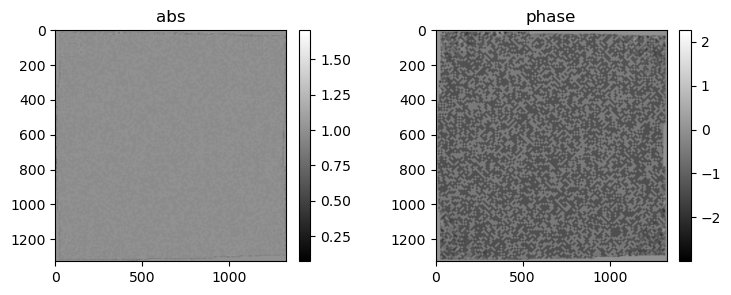

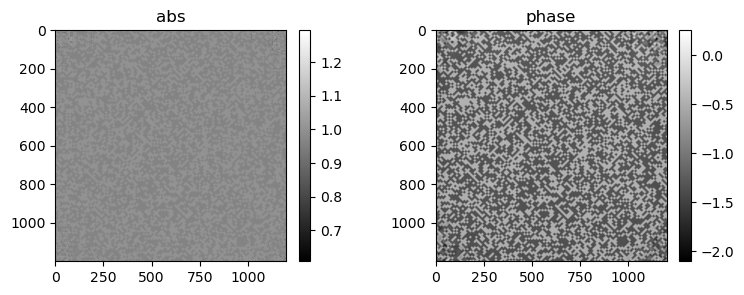

129) gammah=array(0.09409931, dtype=float32), err=3.34758e+00
130) gammah=array(0.09366198, dtype=float32), err=3.28903e+00
131) gammah=array(0.09370685, dtype=float32), err=3.23195e+00
132) gammah=array(0.09400747, dtype=float32), err=3.17624e+00
133) gammah=array(0.09455803, dtype=float32), err=3.12189e+00
134) gammah=array(0.09520163, dtype=float32), err=3.06865e+00
135) gammah=array(0.09554449, dtype=float32), err=3.01669e+00
136) gammah=array(0.09577091, dtype=float32), err=2.96597e+00
137) gammah=array(0.09597945, dtype=float32), err=2.91655e+00
138) gammah=array(0.09604459, dtype=float32), err=2.86835e+00
139) gammah=array(0.09595171, dtype=float32), err=2.82132e+00
140) gammah=array(0.09575641, dtype=float32), err=2.77555e+00
141) gammah=array(0.09580307, dtype=float32), err=2.73083e+00
142) gammah=array(0.09573923, dtype=float32), err=2.68721e+00
143) gammah=array(0.0956009, dtype=float32), err=2.64466e+00
144) gammah=array(0.09531039, dtype=float32), err=2.60313e+00
145) gamm

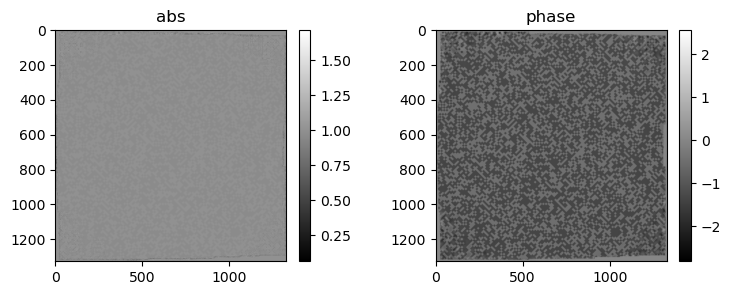

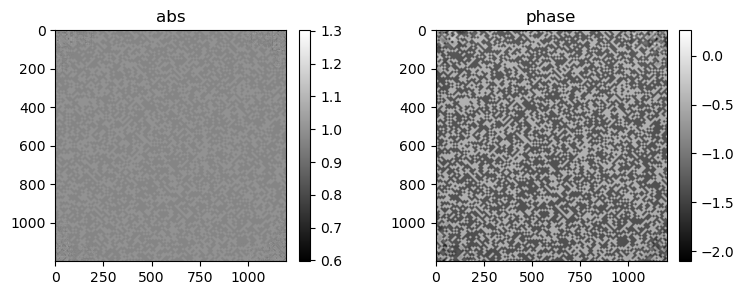

161) gammah=array(0.0950774, dtype=float32), err=2.02362e+00
162) gammah=array(0.09496251, dtype=float32), err=1.99644e+00
163) gammah=array(0.09513017, dtype=float32), err=1.96982e+00
164) gammah=array(0.09520797, dtype=float32), err=1.94374e+00
165) gammah=array(0.09538991, dtype=float32), err=1.91819e+00
166) gammah=array(0.09560371, dtype=float32), err=1.89316e+00
167) gammah=array(0.09555525, dtype=float32), err=1.86856e+00
168) gammah=array(0.09520137, dtype=float32), err=1.84440e+00
169) gammah=array(0.09513766, dtype=float32), err=1.82065e+00
170) gammah=array(0.09513101, dtype=float32), err=1.79725e+00
171) gammah=array(0.0948888, dtype=float32), err=1.77425e+00
172) gammah=array(0.09446362, dtype=float32), err=1.75167e+00
173) gammah=array(0.09441164, dtype=float32), err=1.72948e+00
174) gammah=array(0.09451567, dtype=float32), err=1.70761e+00
175) gammah=array(0.09509047, dtype=float32), err=1.68606e+00
176) gammah=array(0.09533871, dtype=float32), err=1.66493e+00
177) gamma

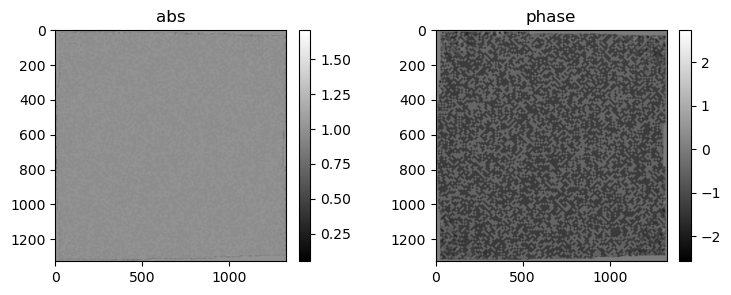

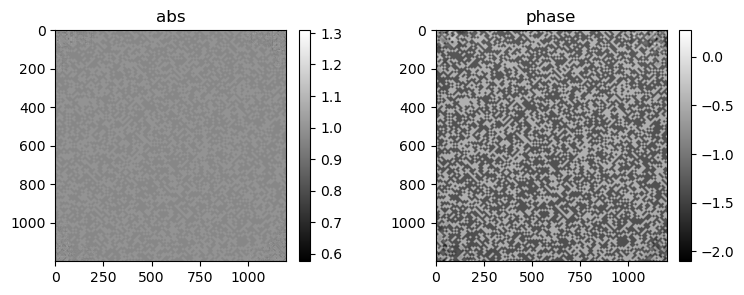

193) gammah=array(0.09575983, dtype=float32), err=1.36414e+00
194) gammah=array(0.0963366, dtype=float32), err=1.34878e+00
195) gammah=array(0.09629796, dtype=float32), err=1.33367e+00
196) gammah=array(0.09642619, dtype=float32), err=1.31880e+00
197) gammah=array(0.09665222, dtype=float32), err=1.30416e+00
198) gammah=array(0.09696002, dtype=float32), err=1.28971e+00
199) gammah=array(0.09664869, dtype=float32), err=1.27552e+00
200) gammah=array(0.09595694, dtype=float32), err=1.26164e+00
201) gammah=array(0.0953374, dtype=float32), err=1.24803e+00
202) gammah=array(0.09463306, dtype=float32), err=1.23469e+00
203) gammah=array(0.09492328, dtype=float32), err=1.22155e+00
204) gammah=array(0.09537844, dtype=float32), err=1.20860e+00
205) gammah=array(0.09619407, dtype=float32), err=1.19583e+00
206) gammah=array(0.09670912, dtype=float32), err=1.18326e+00
207) gammah=array(0.09666649, dtype=float32), err=1.17090e+00
208) gammah=array(0.09676072, dtype=float32), err=1.15876e+00
209) gamma

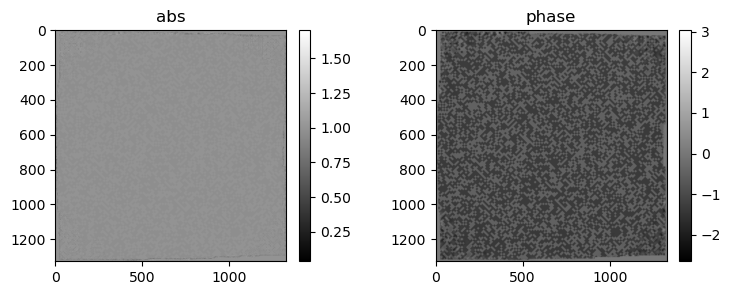

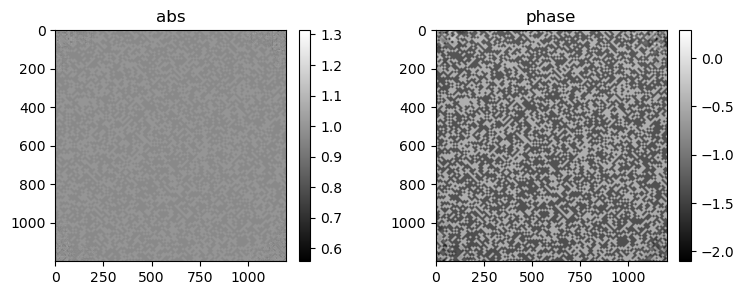

225) gammah=array(0.09724411, dtype=float32), err=9.80262e-01
226) gammah=array(0.09718679, dtype=float32), err=9.71089e-01
227) gammah=array(0.09693264, dtype=float32), err=9.62066e-01
228) gammah=array(0.09670224, dtype=float32), err=9.53184e-01
229) gammah=array(0.09674142, dtype=float32), err=9.44431e-01
230) gammah=array(0.09694552, dtype=float32), err=9.35776e-01
231) gammah=array(0.09669164, dtype=float32), err=9.27241e-01
232) gammah=array(0.09622842, dtype=float32), err=9.18818e-01
233) gammah=array(0.0954429, dtype=float32), err=9.10532e-01
234) gammah=array(0.09432749, dtype=float32), err=9.02397e-01
235) gammah=array(0.09383225, dtype=float32), err=8.94363e-01
236) gammah=array(0.09404393, dtype=float32), err=8.86415e-01
237) gammah=array(0.09496329, dtype=float32), err=8.78519e-01
238) gammah=array(0.09604353, dtype=float32), err=8.70695e-01
239) gammah=array(0.09637628, dtype=float32), err=8.62964e-01
240) gammah=array(0.09639814, dtype=float32), err=8.55370e-01
241) gamm

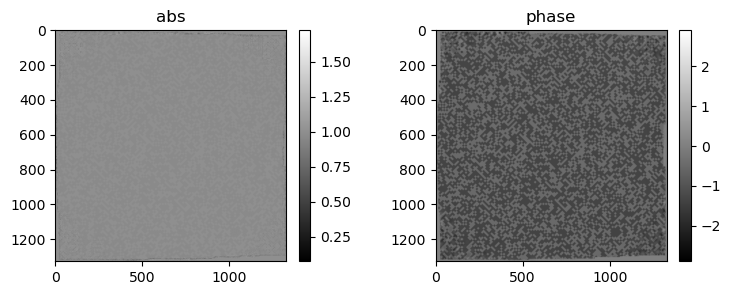

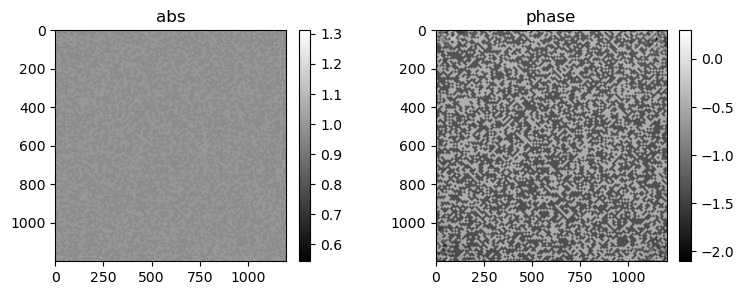

257) gammah=array(0.09438853, dtype=float32), err=7.40766e-01
258) gammah=array(0.09402254, dtype=float32), err=7.34880e-01
259) gammah=array(0.09417375, dtype=float32), err=7.29078e-01
260) gammah=array(0.09429087, dtype=float32), err=7.23364e-01
261) gammah=array(0.09484245, dtype=float32), err=7.17714e-01
262) gammah=array(0.09566721, dtype=float32), err=7.12113e-01
263) gammah=array(0.09658059, dtype=float32), err=7.06554e-01
264) gammah=array(0.0975197, dtype=float32), err=7.01043e-01
265) gammah=array(0.09795005, dtype=float32), err=6.95589e-01
266) gammah=array(0.09839118, dtype=float32), err=6.90199e-01
267) gammah=array(0.09847043, dtype=float32), err=6.84860e-01
268) gammah=array(0.09818161, dtype=float32), err=6.79586e-01
269) gammah=array(0.09786338, dtype=float32), err=6.74385e-01
270) gammah=array(0.09743095, dtype=float32), err=6.69252e-01
271) gammah=array(0.09672479, dtype=float32), err=6.64198e-01
272) gammah=array(0.09621644, dtype=float32), err=6.59219e-01
273) gamm

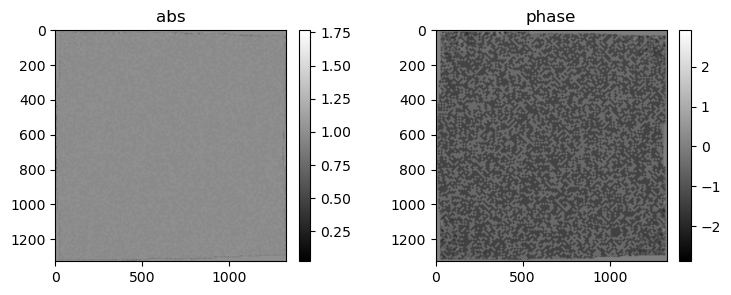

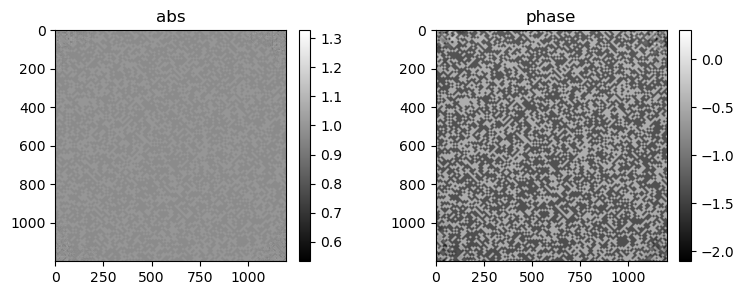

289) gammah=array(0.09620869, dtype=float32), err=5.82821e-01
290) gammah=array(0.09637857, dtype=float32), err=5.78715e-01
291) gammah=array(0.09638755, dtype=float32), err=5.74657e-01
292) gammah=array(0.09609594, dtype=float32), err=5.70659e-01
293) gammah=array(0.09577303, dtype=float32), err=5.66711e-01
294) gammah=array(0.09538011, dtype=float32), err=5.62820e-01
295) gammah=array(0.09519868, dtype=float32), err=5.58983e-01
296) gammah=array(0.0949941, dtype=float32), err=5.55200e-01
297) gammah=array(0.09476883, dtype=float32), err=5.51459e-01
298) gammah=array(0.09471889, dtype=float32), err=5.47759e-01
299) gammah=array(0.09488551, dtype=float32), err=5.44094e-01
300) gammah=array(0.09529856, dtype=float32), err=5.40452e-01
301) gammah=array(0.09551565, dtype=float32), err=5.36837e-01
302) gammah=array(0.0957569, dtype=float32), err=5.33257e-01
303) gammah=array(0.09580647, dtype=float32), err=5.29709e-01
304) gammah=array(0.09553751, dtype=float32), err=5.26199e-01
305) gamma

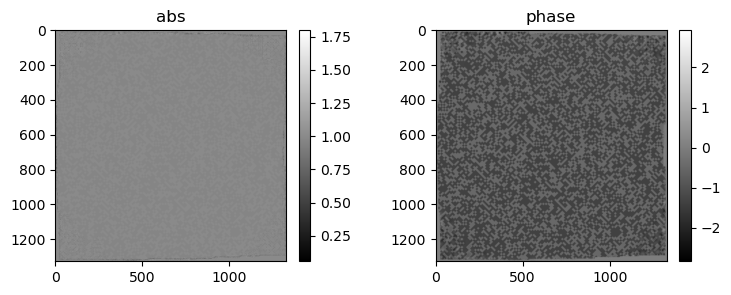

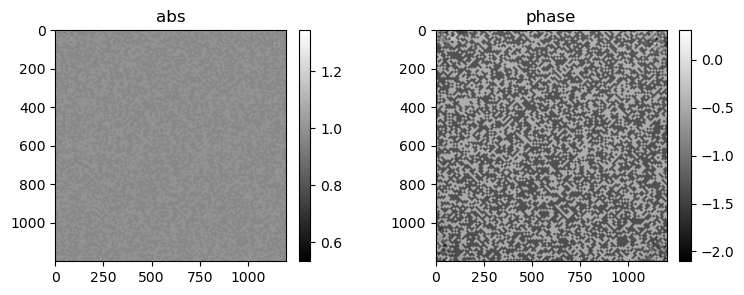

321) gammah=array(0.09539524, dtype=float32), err=4.72652e-01
322) gammah=array(0.09532236, dtype=float32), err=4.69808e-01
323) gammah=array(0.09517141, dtype=float32), err=4.66990e-01
324) gammah=array(0.09508599, dtype=float32), err=4.64192e-01
325) gammah=array(0.09522089, dtype=float32), err=4.61408e-01
326) gammah=array(0.09551508, dtype=float32), err=4.58644e-01
327) gammah=array(0.09598029, dtype=float32), err=4.55899e-01
328) gammah=array(0.0961629, dtype=float32), err=4.53174e-01
329) gammah=array(0.09656189, dtype=float32), err=4.50466e-01
330) gammah=array(0.09661195, dtype=float32), err=4.47773e-01
331) gammah=array(0.0960543, dtype=float32), err=4.45111e-01
332) gammah=array(0.09584315, dtype=float32), err=4.42473e-01
333) gammah=array(0.09577239, dtype=float32), err=4.39864e-01
334) gammah=array(0.09590415, dtype=float32), err=4.37276e-01
335) gammah=array(0.09585171, dtype=float32), err=4.34710e-01
336) gammah=array(0.09587864, dtype=float32), err=4.32162e-01
337) gamma

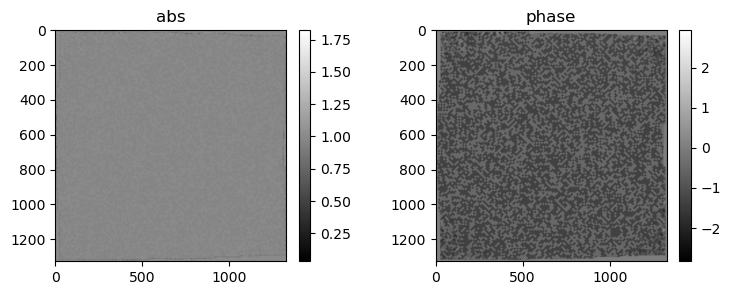

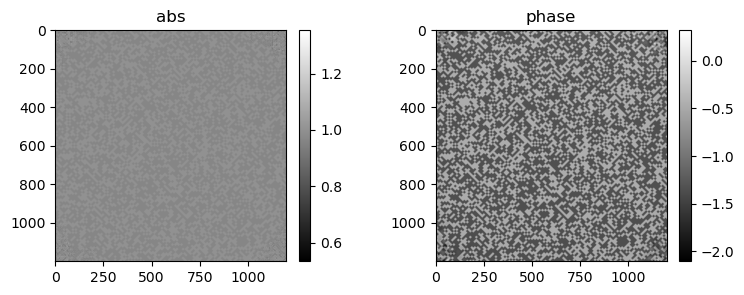

353) gammah=array(0.09700553, dtype=float32), err=3.92651e-01
354) gammah=array(0.09676683, dtype=float32), err=3.90514e-01
355) gammah=array(0.09663652, dtype=float32), err=3.88396e-01
356) gammah=array(0.09675371, dtype=float32), err=3.86296e-01
357) gammah=array(0.09629107, dtype=float32), err=3.84219e-01
358) gammah=array(0.09638974, dtype=float32), err=3.82162e-01
359) gammah=array(0.09609618, dtype=float32), err=3.80126e-01
360) gammah=array(0.09612574, dtype=float32), err=3.78114e-01
361) gammah=array(0.09544358, dtype=float32), err=3.76131e-01
362) gammah=array(0.09478717, dtype=float32), err=3.74176e-01
363) gammah=array(0.09420091, dtype=float32), err=3.72246e-01
364) gammah=array(0.0942334, dtype=float32), err=3.70336e-01
365) gammah=array(0.0949685, dtype=float32), err=3.68443e-01
366) gammah=array(0.09511139, dtype=float32), err=3.66569e-01
367) gammah=array(0.09557405, dtype=float32), err=3.64715e-01
368) gammah=array(0.09576248, dtype=float32), err=3.62878e-01
369) gamma

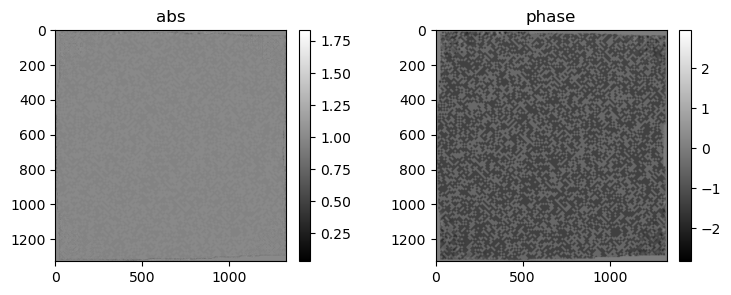

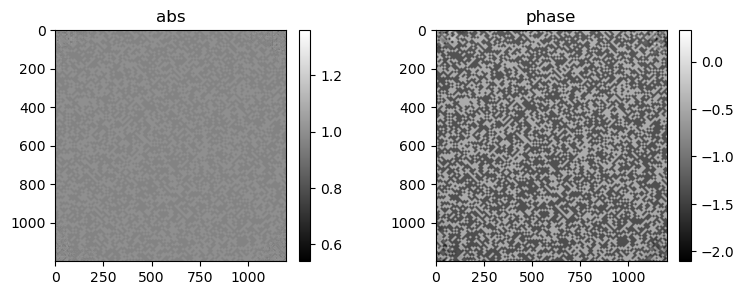

385) gammah=array(0.09594276, dtype=float32), err=3.33826e-01
386) gammah=array(0.09554885, dtype=float32), err=3.32246e-01
387) gammah=array(0.09554707, dtype=float32), err=3.30683e-01
388) gammah=array(0.09530094, dtype=float32), err=3.29136e-01
389) gammah=array(0.09539118, dtype=float32), err=3.27600e-01
390) gammah=array(0.09545745, dtype=float32), err=3.26076e-01
391) gammah=array(0.09572894, dtype=float32), err=3.24561e-01
392) gammah=array(0.09579631, dtype=float32), err=3.23061e-01
393) gammah=array(0.09596983, dtype=float32), err=3.21574e-01
394) gammah=array(0.09620226, dtype=float32), err=3.20102e-01
395) gammah=array(0.0966254, dtype=float32), err=3.18641e-01
396) gammah=array(0.09650253, dtype=float32), err=3.17194e-01
397) gammah=array(0.09579321, dtype=float32), err=3.15764e-01
398) gammah=array(0.09547485, dtype=float32), err=3.14349e-01
399) gammah=array(0.09516858, dtype=float32), err=3.12943e-01
400) gammah=array(0.09490791, dtype=float32), err=3.11549e-01
401) gamm

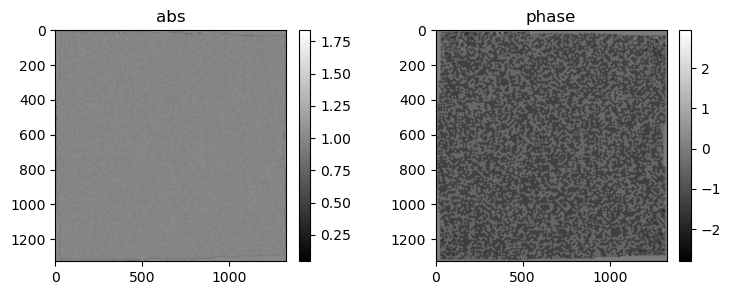

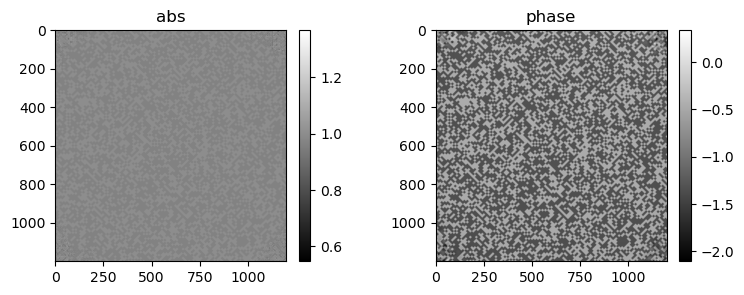

417) gammah=array(0.09438071, dtype=float32), err=2.89148e-01
418) gammah=array(0.0947181, dtype=float32), err=2.87925e-01
419) gammah=array(0.09497184, dtype=float32), err=2.86704e-01
420) gammah=array(0.09512737, dtype=float32), err=2.85497e-01
421) gammah=array(0.09564252, dtype=float32), err=2.84295e-01
422) gammah=array(0.0961026, dtype=float32), err=2.83095e-01
423) gammah=array(0.09679247, dtype=float32), err=2.81898e-01
424) gammah=array(0.09708674, dtype=float32), err=2.80706e-01
425) gammah=array(0.09698138, dtype=float32), err=2.79524e-01
426) gammah=array(0.09634235, dtype=float32), err=2.78353e-01
427) gammah=array(0.09553086, dtype=float32), err=2.77195e-01
428) gammah=array(0.09449075, dtype=float32), err=2.76048e-01
429) gammah=array(0.09402214, dtype=float32), err=2.74912e-01
430) gammah=array(0.09418951, dtype=float32), err=2.73783e-01
431) gammah=array(0.09424238, dtype=float32), err=2.72660e-01
432) gammah=array(0.09451407, dtype=float32), err=2.71545e-01
433) gamma

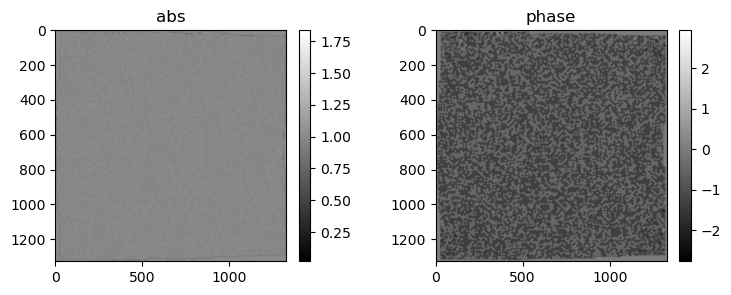

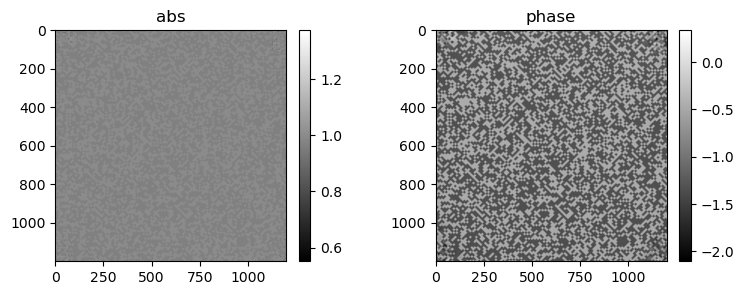

449) gammah=array(0.09509127, dtype=float32), err=2.53638e-01
450) gammah=array(0.09499294, dtype=float32), err=2.52641e-01
451) gammah=array(0.09507569, dtype=float32), err=2.51650e-01
452) gammah=array(0.09510686, dtype=float32), err=2.50665e-01
453) gammah=array(0.09508515, dtype=float32), err=2.49691e-01
454) gammah=array(0.09515034, dtype=float32), err=2.48723e-01
455) gammah=array(0.09488818, dtype=float32), err=2.47762e-01
456) gammah=array(0.0947877, dtype=float32), err=2.46811e-01
457) gammah=array(0.09515025, dtype=float32), err=2.45867e-01
458) gammah=array(0.09487987, dtype=float32), err=2.44932e-01
459) gammah=array(0.09451708, dtype=float32), err=2.44006e-01
460) gammah=array(0.09427176, dtype=float32), err=2.43084e-01
461) gammah=array(0.0941251, dtype=float32), err=2.42168e-01
462) gammah=array(0.09453052, dtype=float32), err=2.41255e-01
463) gammah=array(0.09499107, dtype=float32), err=2.40343e-01
464) gammah=array(0.0956535, dtype=float32), err=2.39431e-01
465) gammah

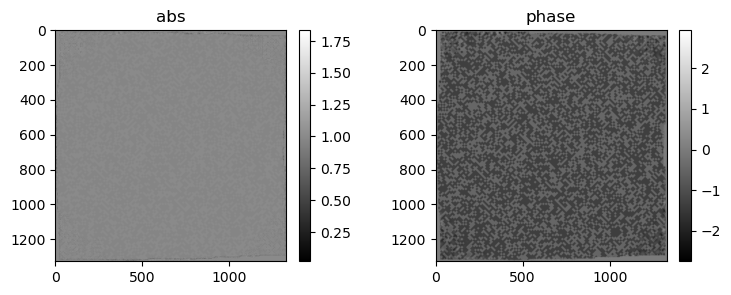

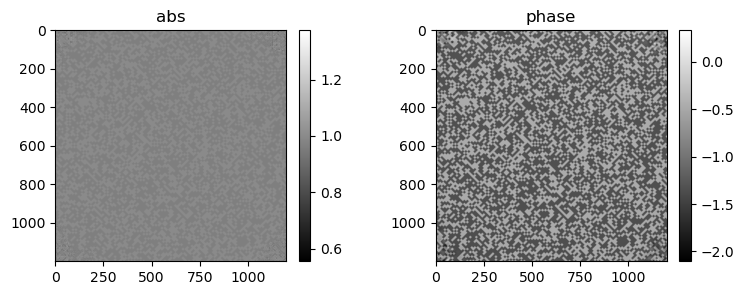

481) gammah=array(0.09432022, dtype=float32), err=2.24871e-01
482) gammah=array(0.09400848, dtype=float32), err=2.24069e-01
483) gammah=array(0.09337327, dtype=float32), err=2.23277e-01
484) gammah=array(0.0936872, dtype=float32), err=2.22489e-01
485) gammah=array(0.0942998, dtype=float32), err=2.21703e-01
486) gammah=array(0.09541239, dtype=float32), err=2.20919e-01
487) gammah=array(0.09573383, dtype=float32), err=2.20138e-01
488) gammah=array(0.09549576, dtype=float32), err=2.19362e-01
489) gammah=array(0.09482513, dtype=float32), err=2.18594e-01
490) gammah=array(0.09425592, dtype=float32), err=2.17833e-01
491) gammah=array(0.09375424, dtype=float32), err=2.17078e-01
492) gammah=array(0.09366468, dtype=float32), err=2.16327e-01
493) gammah=array(0.09370121, dtype=float32), err=2.15580e-01
494) gammah=array(0.09410025, dtype=float32), err=2.14832e-01
495) gammah=array(0.09449547, dtype=float32), err=2.14085e-01
496) gammah=array(0.09501355, dtype=float32), err=2.13341e-01
497) gamma

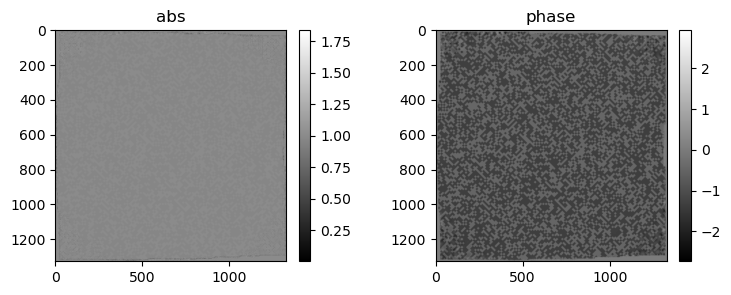

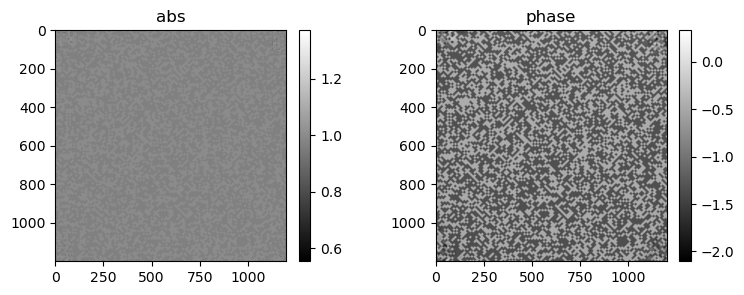

In [10]:
import time
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma

# def hessian2(hpsi,hksi,heta,data):
#     Lksi = Lop(hksi)
#     Leta = Lop(heta)
#     Lpsi = Lop(hpsi)        

#     v1 = cp.abs(Lpsi)-data
#     v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
#     v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3    
#     v4 = cp.real(cp.conj(Lpsi)*Lksi)/cp.abs(Lpsi)
#     v5 = cp.real(cp.conj(Lpsi)*Leta)/cp.abs(Lpsi)
#     return 2*(cp.sum(v1 * cp.conj(v2-v3)) + cp.sum(v4*cp.conj(v5)))

def hessian2(hpsi,hksi,heta,data):
    Lksi = Lop(hksi)
    Leta = Lop(heta)
    Lpsi = Lop(hpsi)        

    v1 = cp.abs(Lpsi)-data
    v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
    v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3        
    return 2*(cp.sum(v1 * cp.conj(v2)) + cp.sum(data*cp.conj(v3)))

def cg_holo(data,ref, init_psi,init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    ref = np.sqrt(ref)
    psi = init_psi.copy()
    prb = init_prb.copy()

    conv = np.zeros(pars['niter'])
    gammaha = np.zeros(pars['niter'])
    gammah=0
    
   
        
    for i in range(pars['niter']):                                        
        fpsi = Lop(Sop(psi)*prb)        
        gradx = 2*LTop(fpsi-data*np.exp(1j*np.angle(fpsi)))                                
        gradpsi = STop(gradx*cp.conj(prb))             
        
        if i==0:
            etapsi = -gradpsi
        else:
            # top
            hpsi = Sop(psi)*prb            
            hksi = Sop(gradpsi)*prb
            heta = Sop(etapsi)*prb

            h2u = hessian2(hpsi,hksi,heta,data)
            
            # bottom
            hpsi = Sop(psi)*prb
            heta = Sop(etapsi)*prb
            h2b = hessian2(hpsi,heta,heta,data)
            
            beta = h2u/h2b
            
            etapsi = -gradpsi + beta*etapsi
            
        #top
        top = -cp.sum(cp.real(gradpsi*cp.conj(etapsi)))
        # bottom
        hpsi = Sop(psi)*prb
        heta = Sop(etapsi)*prb        
        h2b = hessian2(hpsi,heta,heta,data)        

        gammah = top/h2b 
        
        # npp = 17
        # errt = np.zeros(npp)
        # errt2 = np.zeros(npp)
        # if i>-1:
        #     for k in range(0,npp):
        #         psit = psi+(gammah*k/(npp-1))*etapsi
        #         fpsit = Lop(Sop(psit)*prb)
        #         errt[k] = minf(fpsit)    
        #     t = gammah*cp.arange(npp)/(npp-1)
        #     errt2 = minf(Lop(Sop(psi)*prb))-top*t+0.5*h2b*t**2
        #     # plt.plot(gammah.get()*np.arange(17)/16,errt,'.')
        #     # plt.plot(gammah.get()*np.arange(17)/16,errt2.get(),'.')
        #     plt.plot(gammah.get()*np.arange(npp)/(npp-1),errt-errt2.get(),'.')



        #     plt.show()
       
        # print(f'{h2b=}, {gammah=}')
        psi += gammah*etapsi
        
        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)
            err = minf(fpsi)
            conv[i] = err
            gammaha[i] = gammah
            print(f'{i}) {gammah=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
        
    return psi,prb,conv,gammaha

# fully on gpu
rec_psi = recMultiPaganin.copy()
data = cp.array(data00.copy())
ref = cp.array(ref0.copy())

rec_prb = cp.array(np.load(f'{path}/data/prb_{flg}.npy'))
pars = {'niter': 513, 'err_step': 1, 'vis_step': 32}
rec_psi,rec_prb,conv,gammaha = cg_holo(data,ref,rec_psi,rec_prb, pars)
# k = f'cghessians'
# np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
# np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
# np.save(f'data/conv_{k}_{pars['niter']}',conv)
# np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)



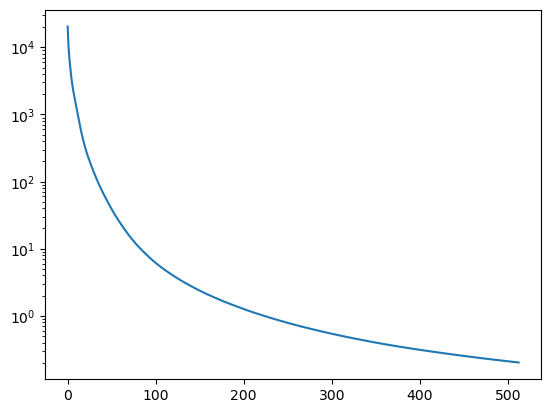

In [12]:
plt.plot(conv)
plt.yscale('log')

In [ ]:
# plt.plot(conv)
# plt.yscale('log')
# mshow_polar(rec_psi[0],show)
# mshow_polar(rec_prb[0],show)